# task-perturb-multiomics-grn
## Post process
### by Jalil Nourisa

In [6]:
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt

import os
import numpy as np
from local_utils import plots

work_dir = '../output/'
cell_types = ['B cells','T cells','Myeloid cells','NK cells']

# Baseline GRNs

In [ ]:
def create_negative_control(tf_n: int=800, sparsity: float=.98):
    import pandas as pd 
    import os
    import numpy as np
    df_train = pd.read_csv(f'../resources/df_train/df_train.csv')

    genes_n = df_train.columns.shape[0]
    X_random = np.random.choice([0, -1, 1], size=(genes_n, tf_n), p=[sparsity, (1-sparsity)/2, (1-sparsity)/2])
    row_names = df_train.columns
    col_names = [f'TF_{i}' for i in range(tf_n)]
    grn_random = pd.DataFrame(X_random, index=row_names, columns=col_names)
    grn_random.reset_index(inplace=True)
    grn_random = pd.melt(grn_random, id_vars=['index'], var_name='TF', value_name='weight')
    grn_random.columns = ['target', 'source', 'weight']
    grn_random = grn_random[['source', 'target', 'weight']]
    grn_random = grn_random[grn_random.weight!=0].reset_index(drop=True)

    print(grn_random.shape)

    grn_random.to_csv(f'../output/benchmarking/baseline_models/negative_control.csv')

create_negative_control()

In [ ]:
tfs_list = np.loadtxt(f'../output/utoronto_human_tfs_v_1.01.txt', dtype=str)
df_train = pd.read_csv(f'../resources/df_train/df_train.csv').set_index(['sm_name','cell_type','plate_name','row'])

In [ ]:
gene_names = df_train.columns
tfs_list =  np.asarray([gene for gene in tfs_list if gene in df_train.columns])
tf_idx = np.asarray([idx for idx, gene in enumerate(df_train.columns) if gene in tfs_list])

In [ ]:
import portia as pt
dataset = pt.GeneExpressionDataset()
for exp_id, data in enumerate(df_train.values):
    dataset.add(pt.Experiment(exp_id, data))
M_bar, S = pt.run(dataset, tf_idx=tf_idx, method='fast', return_sign=True)

def format_grn(scores, S, gene_names):
    tfs = []
    targets = []
    weights = []
    for row_i in range(len(scores)):
        for col_i in range(len(scores[0])):
            score = scores[row_i][col_i]
            if score == 0:
                continue
            s = S[row_i][col_i]
            tf = gene_names[row_i]
            gene = gene_names[col_i]

            tfs.append(tf)
            targets.append(gene)
            weights.append(score*s)

    return pd.DataFrame({'source':tfs, 'target':targets, 'weight':weights})

positive_control = format_grn(M_bar, S, gene_names)

positive_control

positive_control_f = positive_control[positive_control.index.isin(positive_control.weight.abs().sort_values()[-200000:,].index)].reset_index()

positive_control_f.to_csv(f'../output/benchmarking/baseline_models/positive_control.csv')

# Postporcess GRNs

In [ ]:
os.makedirs(f'{work_dir}/benchmarking/grn_models/', exist_ok=True)
os.makedirs(f'{work_dir}/benchmarking/peak_gene_models/', exist_ok=True)

## Subset GRNs

### Celloracle

In [102]:
grn_stack =  []
for cell_type in cell_types:
    grn = pd.read_csv(f'{work_dir}/infer/celloracle/grn/grn_{cell_type}.csv')
    grn = grn[['source', 'target', 'coef_mean']]
    grn.columns = ['source', 'target', 'weight']
    grn['link'] = grn.source + '_' + grn.target
    grn['cell_type'] = cell_type
    grn_stack.append(grn)
celloracle_grn = pd.concat(grn_stack).reset_index(drop=True)


In [105]:
celloracle_average_weights = celloracle_grn.groupby('link')['weight'].mean()

In [113]:
top_links = 50_000
celloracle_cutoff_weights = []
grn_stack_f = []
for i, cell_type in enumerate(cell_types):
    grn_celltype = celloracle_grn[celloracle_grn.cell_type==cell_type]
    grn_celltype = grn_celltype[~(grn_celltype.weight==0)] # remove those with 0 coeff
    print('number of links before top quantile selection: ', grn_celltype.shape[0])
    
    
    grn_celltype_f = grn_celltype.sort_values(by='weight', key=abs, ascending=False).head(top_links)
    
    celloracle_cutoff_weights.append(grn_celltype_f.weight.abs().min())
    print('connections: ', grn_celltype_f.shape)
    print('TFs: ', grn_celltype_f.source.unique().shape)
    print('target gene: ', grn_celltype_f.target.unique().shape)
    grn_stack_f.append(grn_celltype_f)

    if cell_type=='agg_type':
        cell_type='T cells'

celloracle_grn_f = pd.concat(grn_stack_f).reset_index(drop=True)
celloracle_grn_f.to_csv(f'{work_dir}/infer/celloracle/grn/celloracle_grn.csv')

number of links before top quantile selection:  1956884
connections:  (50000, 5)
TFs:  (477,)
target gene:  (5886,)
number of links before top quantile selection:  2050897
connections:  (50000, 5)
TFs:  (419,)
target gene:  (6974,)
number of links before top quantile selection:  1993367
connections:  (50000, 5)
TFs:  (467,)
target gene:  (6346,)
number of links before top quantile selection:  1965008
connections:  (50000, 5)
TFs:  (460,)
target gene:  (5636,)


In [100]:
celloracle_grn_average = celloracle_grn.groupby('cell_type')['weight'].mean()
celloracle_grn_average

cell_type
B cells          0.008754
Myeloid cells    0.010050
NK cells         0.009019
T cells          0.006205
Name: weight, dtype: float64

### Scenicplus

In [52]:
import pandas as pd 
scenicplus_grn = pd.read_csv(f'{work_dir}/infer/scenicplus/grn/scenicplus_grn.csv')

### FigR

In [53]:
figr_grn = pd.read_csv(f'{work_dir}/infer/figr/grn/figr_grn.csv')

### Granie 

In [54]:
grn_granie = pd.read_csv(f'{work_dir}/infer/granie/grn/granie_grn.csv')

### Ananse

In [59]:
# ananse_grns = {}
# for cell_type in cell_types:
#     grn = pd.read_csv(f"{work_dir}/infer/ananse/grn/{cell_type.replace(' ','-')}.tsv", sep='\t')
#     grn[['source', 'target']] = grn['tf_target'].str.split('—', expand=True)
#     grn = grn[['source', 'target', 'prob']] 
#     grn.columns = ['source', 'target', 'weight']
#     ananse_grns[cell_type] = grn

In [60]:
grn_stack = []
top_links = 50_000
for i, cell_type in enumerate(cell_types):
    grn_celltype = ananse_grns[cell_type]
    print('number of links before top quantile selection: ', grn_celltype.shape[0])
    grn_celltype.columns = ['source', 'target', 'weight']
    grn_celltype['cell_type'] = cell_type
    grn_celltype = grn_celltype.sort_values(by='weight', key=abs, ascending=False).head(top_links)
    print('connections: ', grn_celltype.shape)
    print('TFs: ', grn_celltype.source.unique().shape)
    print('target gene: ', grn_celltype.target.unique().shape)
    grn_stack.append(grn_celltype)
ananse_grn = pd.concat(grn_stack).reset_index(drop=True)

In [61]:
ananse_grn.to_csv(f"{outputdir}/grn/ananse_grn.csv")

### scGLUE

In [55]:
from ast import literal_eval
import pandas as pd
df = pd.read_csv(
    f"{work_dir}/infer/scglue/pruned_grn.csv", header=None, skiprows=3,
    usecols=[0, 8], names=["TF", "targets"]
)

tfs_list = []
target_list = []
weight_list = []
for i, (tf, targets) in df.iterrows():
    for target, weight in literal_eval(targets):
        tfs_list.append(tf)
        target_list.append(target)
        weight_list.append(weight)
scglue_grn = pd.DataFrame(np.stack([tfs_list, target_list, weight_list], axis=1), columns=['source','target','weight'])
scglue_grn.weight = scglue_grn.weight.astype(float)
scglue_grn = scglue_grn.drop_duplicates().reset_index(drop=True)
scglue_grn

,source,target,weight
0,ABI3,SERF2,0.492266
1,ABI3,HMGN2,1.978421
2,ABI3,PFN1,1.763803
3,ABI3,DRAP1,2.075658
4,ABI3,ACTB,0.504045
...,...,...,...
51562,ZNF667,LINC00638,0.166595
51563,ZNF667,GDF10,0.023349
51564,ZNF667,BCAS4,0.043807
51565,ZNF667,TCL1A,0.018544


In [ ]:
scglue_grn.to_csv(f"{work_dir}/infer/scglue/grn/scglue_grn.csv")

## Plot CDF

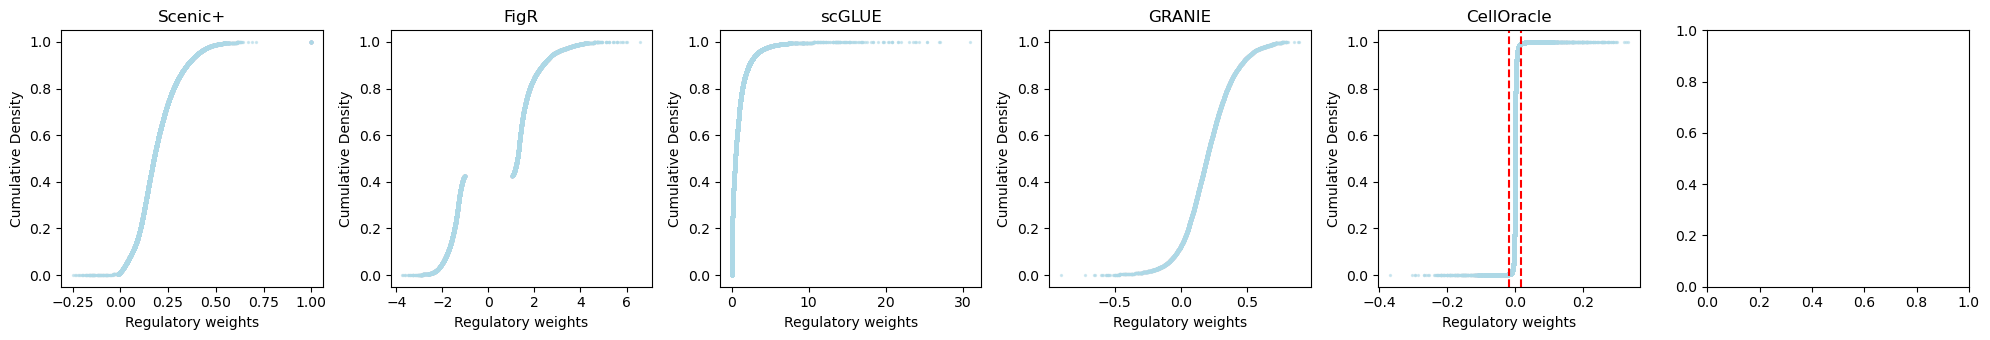

In [116]:
colors_light = ['green', '#ADD8E6', '#FFC0CB', '#90EE90', '#FFD700', '#E6E6FA', 'gray']

# non cell type specific grns
def plot_cumulative_density(data, title='', ax=None):
    # Step 1: Sort the data
    sorted_data = np.sort(data)
    
    # Step 2: Compute the cumulative density values
    cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # Step 3: Plot the data
    if ax is None:
    	fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    else:
    	fig = None
    ax.scatter(sorted_data, cdf, s=2, alpha=.5, color=colors_light[1])
    ax.set_xlabel('Regulatory weights')
    ax.set_ylabel('Cumulative Density')
    ax.set_title(title)
    # ax.grid(True)
    return fig, ax

fig, axes = plt.subplots(1, 6, figsize=(20, 3.5))
for i_plot, (name, grn) in enumerate(zip(['Scenic+','FigR','scGLUE','GRANIE'],[scenicplus_grn, figr_grn, scglue_grn, grn_granie])):
    # norm_weight = grn.weight.values/max(grn.weight.values)
    plot_cumulative_density(grn.weight.values, ax=axes[i_plot], title=name)
# ax.legend(loc='upper left', bbox_to_anchor=(1,1), scatterpoints=1, markerscale=5, prop={'size': 10})
ax=axes[i_plot+1]
plot_cumulative_density(celloracle_average_weights, ax=ax, title='CellOracle')
ax.axvline(np.mean(celloracle_cutoff_weights), color='r', linestyle='--', linewidth=1.5)
ax.axvline(-np.mean(celloracle_cutoff_weights), color='r', linestyle='--', linewidth=1.5)

plt.tight_layout()

## Copy to one place

In [ ]:
grn_model_names = ['figr', 'celloracle', 'granie', 'ananse', 'scglue', 'scenicplus']
for name in grn_model_names:
    grn = pd.read_csv(f'{work_dir}/infer/{name}/grn/{name}_grn.csv', index_col=0)
    if 'cell_type' in grn.columns:
        grn['cell_type'].replace({'agg_type': 'T cells'}, inplace=True)
    
    grn.to_csv(f'../output/benchmarking/grn_models/{name}.csv')
collectRI = pd.read_csv("https://github.com/pablormier/omnipath-static/raw/main/op/collectri-26.09.2023.zip")
collectRI.to_csv(f'../output/benchmarking/grn_models/collectri.csv')

peak_gene_model = ['figr', 'celloracle', 'granie']

for name in peak_gene_model:
    peak_gene = pd.read_csv(f'{work_dir}/infer/{name}/peak_gene.csv', index_col=0)
    peak_gene.to_csv(f'../output/benchmarking/peak_gene_models/{name}.csv')